##### This Notebook has been adapted from a course gave by Robert Gower at AMMI

# First order methods on regression models

    Lab 1 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT


- **Each** student must send their jupyter notebook solutions **before the 5th of July at 23:59**  to **tngoupeyou@aimsammi.org**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [4]:
# Change here using YOUR first and last names
fn1 = "Mory_Moussou_Koulibaly "
ln1 = "Traore"
filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_traore_mory_moussou_koulibaly.ipynb


In [5]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

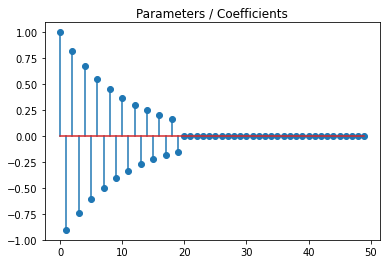

In [7]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [8]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

#ANSWERS

In [11]:
def prox_lasso(x, s,t=1):
    """Proximal operator for the Lasso at x"""    
    return np.sign(x)*np.maximum(np.abs(x)-s*t,0) # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s*np.linalg.norm((x), ord=1) # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x"""    
    return x/(1.+s*t) # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return (s/2.) * (np.linalg.norm((x), ord=2) ** 2)
 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This signific

(-3.0, 3.0)

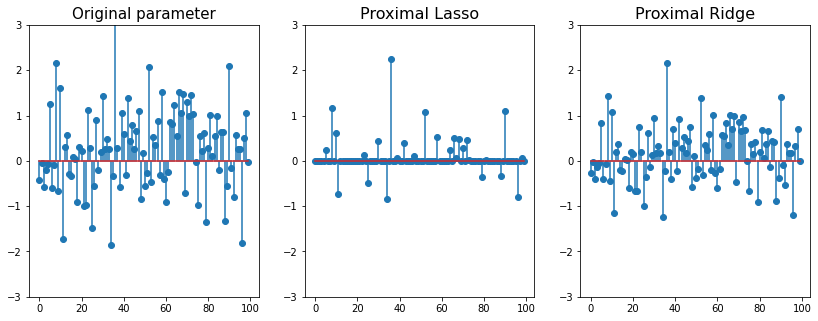

In [12]:
x = randn(100)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(14.0, 5.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=15)
plt.ylim([-3, 3])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-3, 3])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-3, 3])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

#LET US COMMENT THE RESULTS
With the lasso regularization, the coefficients with absolute value less than  $t\cdot s$ vanish since the proximal operator is such that $ \text{sign}(x)(|x|-t\cdot s)_{+} $. The non-zero coefficients is decreasing by the constant scalar $t\cdot s$. We can see that the L1 norm produces sparsity.

This value of the coefficients is smaller but still positive with a ridge regularization,. More precisely, the magnitude of the coefficients is narrowed by the same factor $\frac{1}{1 + t\cdot s}$.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

#Answers

In [16]:
def loss_linreg(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    result=-1/(len(b)) * np.dot(A.T, b - np.dot(A,x))
    return result

def loss_logreg(x):
    u = b * A.dot(x)
    return np.sum(np.log(1 + np.exp(-u))) / n_samples

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    result=sum((-b[i]*np.transpose(A[i, :]) * np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) / (len(b) * (1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x)))) for i in range(len(b)))

    return result

# TO BE COMPLETED

#check gradient

In [17]:
from scipy.optimize import check_grad
A,b = simu_linreg(coefs)
print("Check grad_linreg:", check_grad(loss_linreg, grad_linreg, x0=randn(A.shape[1])))
A,b = simu_logreg(coefs)
print("Check grad_logreg:", check_grad(loss_logreg, grad_logreg, x0=randn(A.shape[1])))

Check grad_linreg: 3.3963379402777666e-06
Check grad_logreg: 1.352530901220983e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` below that implements the 
  ISTA (Proximal Gradient Descent) algorithm</li>
    <li> BONUS QUESTION:  Implement FISTA (Accelerated Proximal 
  Gradient Descent) algorithm as described at the bottom
    </ul>
</div>

#Answers

In [18]:
# TO BE COMPLETED

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    result=1/(len(b)) * np.linalg.norm(np.dot(A.T,A), ord=2)
    return result
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    
    # TODO
    result=1/(4. * len(b)) * np.linalg.norm(A, ord=2)**2
    return result 
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
          x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x = prox_g(x - step*grad_f(x), s, step)

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Try and implement the FISTA algorithm (detailed in maths below)

FISTA Algorithm:
$$\begin{array}{l}
\mbox{Set } w^1=0=z^1, \beta^1 =1\\
\mbox{for }t=1,2,3, \ldots, T \quad  \\
\qquad \displaystyle w^{t+1} = \mbox{prox}_{\left. \lambda R \right/ \mathcal{L}}\left( z^t - \frac{1}{\mathcal{L}} \nabla L(z^t)\right) \\
\qquad \displaystyle \beta^{t+1} = \frac{1+\sqrt{1+4(\beta^t)^2}}{2}\\
\qquad \displaystyle  z^{t+1} = w^{t+1} + \frac{\beta^t -1}{\beta^{t+1}} (w^{t+1} -w^{t})\\
\mbox{Output } w^{T+1}
\end{array}$$

In [19]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z - step*grad_f(z),s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        x, z, t = x_new, z_new, t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [20]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2
s

0.01

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

#LET US Compute a precise minimum and a precise minimizer of the linear regression with ridge penalization problem using the parameters give above. This can be done by using FISTA with 1000 iterations.

In [23]:
# Minimum and minimizer of the linear regression with ridge penalization
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
X, obj, err = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
minimum = obj[-1]
minimizer = X[-1]
print("minimum:", minimum)
print("minimizer:", minimizer)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.83e-01
      10 | 4.78e-01 | 1.26e-01
      20 | 4.77e-01 | 1.26e-01
      30 | 4.77e-01 | 1.24e-01
      40 | 4.77e-01 | 1.25e-01
      50 | 4.77e-01 | 1.24e-01
      60 | 4.77e-01 | 1.24e-01
      70 | 4.77e-01 | 1.24e-01
      80 | 4.77e-01 | 1.24e-01
      90 | 4.77e-01 | 1.24e-01
     100 | 4.77e-01 | 1.24e-01
     110 | 4.77e-01 | 1.24e-01
     120 | 4.77e-01 | 1.24e-01
     130 | 4.77e-01 | 1.24e-01
     140 | 4.77e-01 | 1.24e-01
     150 | 4.77e-01 | 1.24e-01
     160 | 4.77e-01 | 1.24e-01
     170 | 4.77e-01 | 1.24e-01
     180 | 4.77e-01 | 1.24e-01
     190 | 4.77e-01 | 1.24e-01
     200 | 4.77e-01 | 1.24e-01
     210 | 4.77e-01 | 1.24e-01
     220 | 4.77e-01 | 1.24e-01
     230 | 4.77e-01 | 1.24e-01
     240 | 4.77e-01 | 1.24e-01
     250 | 4.77e-01 | 1.24e-01
     260 | 4.77e-01 | 1.24e-01
     270 | 4.77e-01 | 1.24e-01
     280 | 4.77e-01 | 1.24e-01
     290 | 4.77e-01 | 1.24e-01
     300 | 4.7

#Let us Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

#1) Study of the convergence for the ridge penalization.


-Convergence of the term (it can be viewed as a distance to the minimizer)


In [24]:
# Ridge penalization : 
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
Xi_lin, obji_lin, erri_lin = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_lin, objf_lin, errf_lin = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_logreg(A)
Xi_log, obji_log, erri_log = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_log, objf_log, errf_log = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s, n_iter=1000,x_true=coefs, verbose=True)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.30e+00 | 8.82e-01
      10 | 6.12e-01 | 3.15e-01
      20 | 5.51e-01 | 1.64e-01
      30 | 5.44e-01 | 1.32e-01
      40 | 5.44e-01 | 1.26e-01
      50 | 5.43e-01 | 1.25e-01
      60 | 5.43e-01 | 1.25e-01
      70 | 5.43e-01 | 1.25e-01
      80 | 5.43e-01 | 1.25e-01
      90 | 5.43e-01 | 1.25e-01
     100 | 5.43e-01 | 1.25e-01
     110 | 5.43e-01 | 1.25e-01
     120 | 5.43e-01 | 1.25e-01
     130 | 5.43e-01 | 1.25e-01
     140 | 5.43e-01 | 1.25e-01
     150 | 5.43e-01 | 1.25e-01
     160 | 5.43e-01 | 1.25e-01
     170 | 5.43e-01 | 1.25e-01
     180 | 5.43e-01 | 1.25e-01
     190 | 5.43e-01 | 1.25e-01
     200 | 5.43e-01 | 1.25e-01
     210 | 5.43e-01 | 1.25e-01
     220 | 5.43e-01 | 1.25e-01
     230 | 5.43e-01 | 1.25e-01
     240 | 5.43e-01 | 1.25e-01
     250 | 5.43e-01 | 1.25e-01
     260 | 5.43e-01 | 1.25e-01
     270 | 5.43e-01 | 1.25e-01
     280 | 5.43e-01 | 1.25e-01
     290 | 5.43e-01 | 1.25e-01
     300 | 5.43

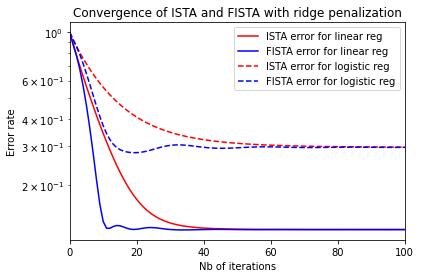

In [25]:

plt.plot(erri_lin,'r',label = "ISTA error for linear reg")
plt.plot(errf_lin,'b',label = "FISTA error for linear reg")
plt.plot(erri_log,'r--',label = "ISTA error for logistic reg")
plt.plot(errf_log,'b--',label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Convergence of ISTA and FISTA with ridge penalization")
plt.xlim(0,100)
plt.show()

- 

-Convergence in terms of distance to the minimum. Let us do the plot here also

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


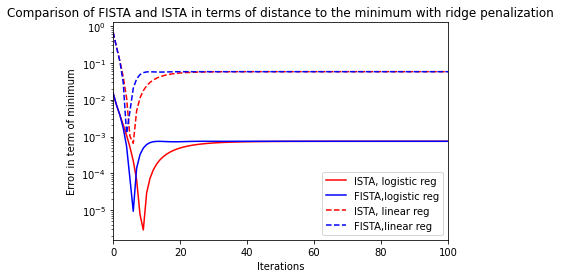

In [42]:
true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)
plt.plot((obji_log- true_obj_log)**2,'r',label = "ISTA, logistic reg")
plt.plot((objf_log- true_obj_log)**2,'b',label = "FISTA,logistic reg")
plt.plot((obji_lin- true_obj_lin)**2,'r--',label = "ISTA, linear reg")
plt.plot((objf_lin- true_obj_lin)**2,'b--',label = "FISTA,linear reg")
ax = plt.subplot(111)
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in term of minimum")
plt.title("Comparison of FISTA and ISTA in terms of distance to the minimum with ridge penalization")
plt.xlim(0,100)
plt.show()

#Study of the convergence with lasso penalization.

In [43]:
 #Lasso penalization : 
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_linreg(A)
Xi_lin, obji_lin, erri_lin = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_lin, objf_lin, errf_lin = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
step=1/lip_logreg(A)
Xi_log, obji_log, erri_log = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)
Xf_log, objf_log, errf_log = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s, n_iter=1000,x_true=coefs, verbose=True)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.30e+00 | 8.91e-01
      10 | 6.48e-01 | 3.32e-01
      20 | 5.87e-01 | 1.80e-01
      30 | 5.80e-01 | 1.44e-01
      40 | 5.80e-01 | 1.34e-01
      50 | 5.80e-01 | 1.31e-01
      60 | 5.80e-01 | 1.30e-01
      70 | 5.80e-01 | 1.30e-01
      80 | 5.80e-01 | 1.29e-01
      90 | 5.80e-01 | 1.29e-01
     100 | 5.80e-01 | 1.29e-01
     110 | 5.80e-01 | 1.29e-01
     120 | 5.80e-01 | 1.29e-01
     130 | 5.80e-01 | 1.29e-01
     140 | 5.80e-01 | 1.29e-01
     150 | 5.80e-01 | 1.29e-01
     160 | 5.80e-01 | 1.29e-01
     170 | 5.80e-01 | 1.29e-01
     180 | 5.80e-01 | 1.29e-01
     190 | 5.80e-01 | 1.29e-01
     200 | 5.80e-01 | 1.29e-01
     210 | 5.80e-01 | 1.29e-01
     220 | 5.80e-01 | 1.29e-01
     230 | 5.80e-01 | 1.29e-01
     240 | 5.80e-01 | 1.29e-01
     250 | 5.80e-01 | 1.29e-01
     260 | 5.80e-01 | 1.29e-01
     270 | 5.80e-01 | 1.29e-01
     280 | 5.80e-01 | 1.29e-01
     290 | 5.80e-01 | 1.29e-01
     300 | 5.80

#-Convergence in terms of distance to the minimizer  - lasso penalization.


Let us do the plot

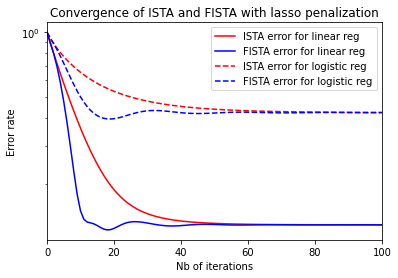

In [44]:
#linear regression
plt.plot(erri_lin,'r',label = "ISTA error for linear reg")
plt.plot(errf_lin,'b',label = "FISTA error for linear reg")
plt.plot(erri_log,'r--',label = "ISTA error for logistic reg")
plt.plot(errf_log,'b--',label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Convergence of ISTA and FISTA with lasso penalization")
plt.xlim(0,100)
plt.show()


## Convergence in terms of distance to the minimum  - lasso penalization
Let us do the plot here

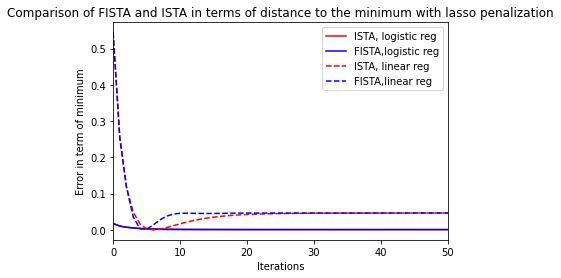

In [47]:

true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)

ax.set_yscale('log')
plt.plot((obji_log- true_obj_log)**2,'r',label = "ISTA, logistic reg")
plt.plot((objf_log- true_obj_log)**2,'b',label = "FISTA,logistic reg")
plt.plot((obji_lin- true_obj_lin)**2,'r--',label = "ISTA, linear reg")
plt.plot((objf_lin- true_obj_lin)**2,'b--',label = "FISTA,linear reg")

ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in term of minimum")
plt.title("Comparison of FISTA and ISTA in terms of distance to the minimum with lasso penalization")
plt.xlim(0,50)
plt.show()


#Comments 
We see that the FISTA algorithm (blue line) converges faster than the ISTA algorithm (red line). We see also, for both algorithms and penalizations, the error is bigger when a logistic regression is used.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

#Answers
#- Influence of the correlation of the features. Here we will use two datasets for simulations.

#FISTA algorithm

-This part concerns the linear regression with ridge and lasso penalization.

In [55]:
Constante_lin = []

A, b = simu_linreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
low_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
med_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
high_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200) 

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.60e-01 | 7.03e-01
      10 | 1.04e-01 | 1.88e-01
      20 | 1.03e-01 | 1.90e-01
      30 | 1.03e-01 | 1.88e-01
      40 | 1.03e-01 | 1.89e-01
      50 | 1.03e-01 | 1.89e-01
      60 | 1.03e-01 | 1.89e-01
      70 | 1.03e-01 | 1.89e-01
      80 | 1.03e-01 | 1.89e-01
      90 | 1.03e-01 | 1.89e-01
     100 | 1.03e-01 | 1.89e-01
     110 | 1.03e-01 | 1.89e-01
     120 | 1.03e-01 | 1.89e-01
     130 | 1.03e-01 | 1.89e-01
     140 | 1.03e-01 | 1.89e-01
     150 | 1.03e-01 | 1.89e-01
     160 | 1.03e-01 | 1.89e-01
     170 | 1.03e-01 | 1.89e-01
     180 | 1.03e-01 | 1.89e-01
     190 | 1.03e-01 | 1.89e-01
     200 | 1.03e-01 | 1.89e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.03e-01 | 7.06e-01
      10 | 1.79e-01 | 1.62e-01
      20 | 1.78e-01 | 1.66e-01
      30 | 1.78e-01 | 1.64e-01
      40 | 1.78e-01 | 1.65e-01
      50 | 1.78e-01 | 1.65e-01
      60 | 1.78e-01 | 1.65e-01
      70 | 1.78e-01 

- Here we have the logistic regression with ridge and lasso penalization.

In [56]:

Constante_log = []

A, b = simu_logreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
low_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
med_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
high_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.06e-01 | 8.28e-01
      10 | 1.02e-01 | 6.10e-01
      20 | 1.10e-01 | 7.05e-01
      30 | 1.06e-01 | 6.58e-01
      40 | 1.07e-01 | 6.66e-01
      50 | 1.07e-01 | 6.72e-01
      60 | 1.07e-01 | 6.65e-01
      70 | 1.07e-01 | 6.68e-01
      80 | 1.07e-01 | 6.68e-01
      90 | 1.07e-01 | 6.67e-01
     100 | 1.07e-01 | 6.68e-01
     110 | 1.07e-01 | 6.67e-01
     120 | 1.07e-01 | 6.67e-01
     130 | 1.07e-01 | 6.68e-01
     140 | 1.07e-01 | 6.67e-01
     150 | 1.07e-01 | 6.67e-01
     160 | 1.07e-01 | 6.67e-01
     170 | 1.07e-01 | 6.67e-01
     180 | 1.07e-01 | 6.67e-01
     190 | 1.07e-01 | 6.67e-01
     200 | 1.07e-01 | 6.67e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.32e-01 | 8.45e-01
      10 | 1.67e-01 | 5.17e-01
      20 | 1.74e-01 | 5.35e-01
      30 | 1.70e-01 | 5.24e-01
      40 | 1.71e-01 | 5.25e-01
      50 | 1.71e-01 | 5.27e-01
      60 | 1.71e-01 | 5.25e-01
      70 | 1.71e-01 

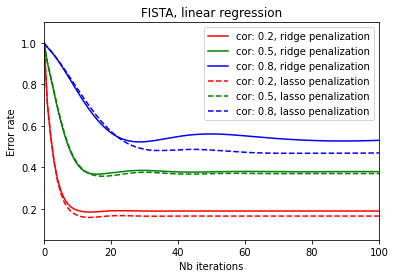

lipschitz constant: [2.5101199759633066, 3.7127198446585674, 8.072953959131166]
lipschitz constant:  [0.6005105911632844, 0.9691137665363876, 2.2740367297382433]


In [57]:
# Linear regression, both penalizations
fig = plt.figure()
plt.plot(low_rf[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_rf[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_rf[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_lf[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_lf[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_lf[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('FISTA, linear regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

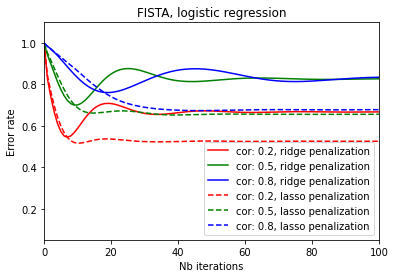

lipschitz constant: [2.5101199759633066, 3.7127198446585674, 8.072953959131166]
lipschitz constant:  [0.6005105911632844, 0.9691137665363876, 2.2740367297382433]


In [65]:
 #Logistic regression
fig = plt.figure()
plt.plot(low_log_rf[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_log_rf[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_log_rf[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_log_lf[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_log_lf[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_log_lf[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('FISTA, logistic regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

#ISTA algorithm

- Here we have linear regression with ridge and lasso penalization.

In [66]:
Constante_lin = []

A, b = simu_linreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
low_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
med_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
high_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.45e-01 | 7.50e-01
      10 | 1.11e-01 | 2.55e-01
      20 | 1.11e-01 | 2.24e-01
      30 | 1.11e-01 | 2.19e-01
      40 | 1.11e-01 | 2.18e-01
      50 | 1.12e-01 | 2.18e-01
      60 | 1.12e-01 | 2.17e-01
      70 | 1.12e-01 | 2.17e-01
      80 | 1.12e-01 | 2.17e-01
      90 | 1.12e-01 | 2.17e-01
     100 | 1.12e-01 | 2.17e-01
     110 | 1.12e-01 | 2.17e-01
     120 | 1.12e-01 | 2.17e-01
     130 | 1.12e-01 | 2.17e-01
     140 | 1.12e-01 | 2.17e-01
     150 | 1.12e-01 | 2.17e-01
     160 | 1.12e-01 | 2.17e-01
     170 | 1.12e-01 | 2.17e-01
     180 | 1.12e-01 | 2.17e-01
     190 | 1.12e-01 | 2.17e-01
     200 | 1.12e-01 | 2.17e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.84e-01 | 7.52e-01
      10 | 1.83e-01 | 2.48e-01
      20 | 1.85e-01 | 2.13e-01
      30 | 1.86e-01 | 2.08e-01
      40 | 1.86e-01 | 2.06e-01
      50 | 1.86e-01 | 2.06e-01
      60 | 1.86e-01 | 2.06e-01
      70 | 1.86e-01 | 

- Here we have logistic regression with ridge and lasso penalization.

In [67]:
Constante_log = []

A, b = simu_logreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
low_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
med_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
high_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.15e-01 | 8.69e-01
      10 | 1.02e-01 | 5.95e-01
      20 | 1.05e-01 | 5.82e-01
      30 | 1.08e-01 | 5.92e-01
      40 | 1.10e-01 | 6.01e-01
      50 | 1.11e-01 | 6.07e-01
      60 | 1.11e-01 | 6.10e-01
      70 | 1.11e-01 | 6.12e-01
      80 | 1.12e-01 | 6.14e-01
      90 | 1.12e-01 | 6.14e-01
     100 | 1.12e-01 | 6.14e-01
     110 | 1.12e-01 | 6.15e-01
     120 | 1.12e-01 | 6.15e-01
     130 | 1.12e-01 | 6.15e-01
     140 | 1.12e-01 | 6.15e-01
     150 | 1.12e-01 | 6.15e-01
     160 | 1.12e-01 | 6.15e-01
     170 | 1.12e-01 | 6.15e-01
     180 | 1.12e-01 | 6.15e-01
     190 | 1.12e-01 | 6.15e-01
     200 | 1.12e-01 | 6.15e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.37e-01 | 8.83e-01
      10 | 1.57e-01 | 6.14e-01
      20 | 1.65e-01 | 5.64e-01
      30 | 1.69e-01 | 5.49e-01
      40 | 1.70e-01 | 5.43e-01
      50 | 1.71e-01 | 5.40e-01
      60 | 1.72e-01 | 5.39e-01
      70 | 1.72e-01 | 

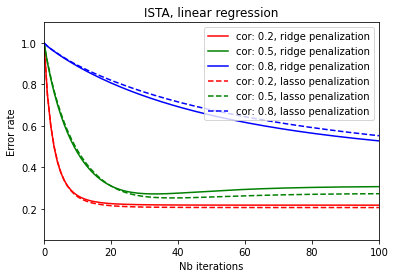

lipschitz constant: [2.4240728914729197, 3.843278389598349, 8.99267561868354]
lipschitz constant:  [0.5960455999639291, 0.9999567086425479, 2.351951620272524]


In [68]:
# Linear regression

fig = plt.figure()
plt.plot(low_r[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_r[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_r[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_l[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_l[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_l[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('ISTA, linear regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

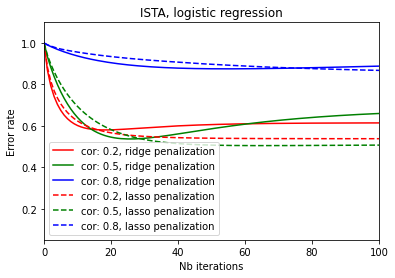

lipschitz constant: [2.4240728914729197, 3.843278389598349, 8.99267561868354]
lipschitz constant:  [0.5960455999639291, 0.9999567086425479, 2.351951620272524]


In [69]:
 #Logistic regression

fig = plt.figure()
plt.plot(low_log_r[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_log_r[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_log_r[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_log_l[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_log_l[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_log_l[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('ISTA, logistic regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

#FISTA vs ISTA



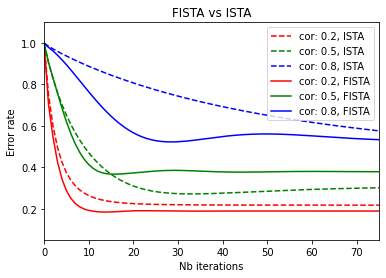

In [70]:
fig = plt.figure()
plt.plot(low_r[2], 'r--', label = 'cor: 0.2, ISTA')
plt.plot(med_r[2], 'g--', label = 'cor: 0.5, ISTA')
plt.plot(high_r[2], 'b--', label = 'cor: 0.8, ISTA')
plt.plot(low_rf[2], 'r', label = 'cor: 0.2, FISTA')
plt.plot(med_rf[2], 'g', label = 'cor: 0.5, FISTA')
plt.plot(high_rf[2], 'b', label = 'cor: 0.8, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 75)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA')
plt.legend()
plt.show()

#Let us comment the result.
Here we see that FISTA is better than ISTA in all the curves whith high correlation.

# - Influence of the level of ridge penalization

#FISTA ALGORITHM

In [71]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin1f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0, n_iter =200)
lin2f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
lin3f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin4f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.25, n_iter =200)
lin5f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.8, n_iter =200)
lin6f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=1, n_iter =200)
lin7f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.20e-01 | 9.03e-01
      10 | 7.92e-02 | 3.23e-01
      20 | 7.58e-02 | 3.71e-01
      30 | 7.56e-02 | 3.49e-01
      40 | 7.56e-02 | 3.42e-01
      50 | 7.56e-02 | 3.49e-01
      60 | 7.56e-02 | 3.48e-01
      70 | 7.56e-02 | 3.46e-01
      80 | 7.56e-02 | 3.48e-01
      90 | 7.56e-02 | 3.47e-01
     100 | 7.56e-02 | 3.47e-01
     110 | 7.56e-02 | 3.47e-01
     120 | 7.56e-02 | 3.47e-01
     130 | 7.56e-02 | 3.47e-01
     140 | 7.56e-02 | 3.47e-01
     150 | 7.56e-02 | 3.47e-01
     160 | 7.56e-02 | 3.47e-01
     170 | 7.56e-02 | 3.47e-01
     180 | 7.56e-02 | 3.47e-01
     190 | 7.56e-02 | 3.47e-01
     200 | 7.56e-02 | 3.47e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.22e-01 | 9.03e-01
      10 | 1.23e-01 | 3.30e-01
      20 | 1.30e-01 | 3.37e-01
      30 | 1.27e-01 | 3.25e-01
      40 | 1.27e-01 | 3.23e-01
      50 | 1.28e-01 | 3.26e-01
      60 | 1.27e-01 | 3.25e-01
      70 | 1.27e-01 

In [72]:
# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log1f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0, n_iter =200)
log2f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
log3f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log4f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.25, n_iter =200)
log5f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.8, n_iter =200)
log6f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=1, n_iter =200)
log7f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.21e-01 | 9.31e-01
      10 | 8.03e-02 | 7.28e-01
      20 | 7.47e-02 | 1.12e+00
      30 | 7.42e-02 | 1.39e+00
      40 | 7.42e-02 | 1.48e+00
      50 | 7.42e-02 | 1.46e+00
      60 | 7.42e-02 | 1.40e+00
      70 | 7.42e-02 | 1.35e+00
      80 | 7.42e-02 | 1.34e+00
      90 | 7.42e-02 | 1.36e+00
     100 | 7.42e-02 | 1.38e+00
     110 | 7.42e-02 | 1.40e+00
     120 | 7.42e-02 | 1.39e+00
     130 | 7.42e-02 | 1.38e+00
     140 | 7.42e-02 | 1.37e+00
     150 | 7.42e-02 | 1.37e+00
     160 | 7.42e-02 | 1.37e+00
     170 | 7.42e-02 | 1.38e+00
     180 | 7.42e-02 | 1.38e+00
     190 | 7.42e-02 | 1.38e+00
     200 | 7.42e-02 | 1.38e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.22e-01 | 9.32e-01
      10 | 1.25e-01 | 6.70e-01
      20 | 1.35e-01 | 6.85e-01
      30 | 1.30e-01 | 6.72e-01
      40 | 1.31e-01 | 6.76e-01
      50 | 1.31e-01 | 6.76e-01
      60 | 1.31e-01 | 6.75e-01
      70 | 1.31e-01 

#Plot 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


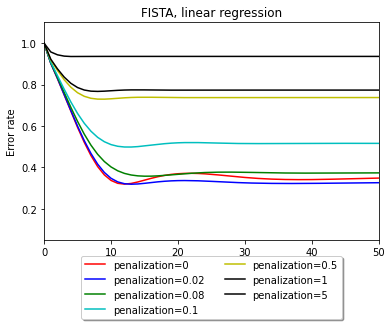

In [73]:
#Linear regression
fig = plt.figure()
plt.plot(lin1f[2], 'r', label = 'penalization=0')
plt.plot(lin2f[2], 'b', label = 'penalization=0.02')
plt.plot(lin3f[2], 'g', label = 'penalization=0.08')
plt.plot(lin4f[2], 'c', label = 'penalization=0.1')
plt.plot(lin5f[2], 'y', label = 'penalization=0.5')
plt.plot(lin6f[2], 'k', label = 'penalization=1')
plt.plot(lin7f[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


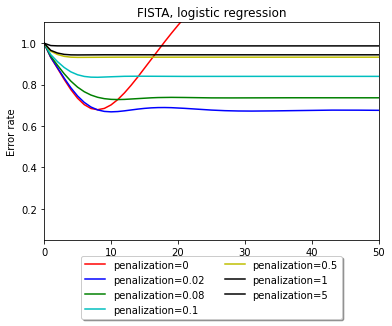

In [74]:
#Logistic regression
fig = plt.figure()
plt.plot(log1f[2], 'r', label = 'penalization=0')
plt.plot(log2f[2], 'b', label = 'penalization=0.02')
plt.plot(log3f[2], 'g', label = 'penalization=0.08')
plt.plot(log4f[2], 'c', label = 'penalization=0.1')
plt.plot(log5f[2], 'y', label = 'penalization=0.5')
plt.plot(log6f[2], 'k', label = 'penalization=1')
plt.plot(log7f[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

#ISTA ALGORITHM

In [75]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin1= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0, n_iter =200)
lin2 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
lin3 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.08, n_iter =200)
lin4 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin5 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.5, n_iter =200)
lin6 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=1, n_iter =200)
lin7 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.51e-01 | 9.09e-01
      10 | 1.04e-01 | 4.36e-01
      20 | 7.48e-02 | 2.87e-01
      30 | 6.60e-02 | 2.77e-01
      40 | 6.31e-02 | 3.00e-01
      50 | 6.21e-02 | 3.20e-01
      60 | 6.17e-02 | 3.34e-01
      70 | 6.16e-02 | 3.43e-01
      80 | 6.16e-02 | 3.48e-01
      90 | 6.15e-02 | 3.51e-01
     100 | 6.15e-02 | 3.53e-01
     110 | 6.15e-02 | 3.54e-01
     120 | 6.15e-02 | 3.55e-01
     130 | 6.15e-02 | 3.55e-01
     140 | 6.15e-02 | 3.56e-01
     150 | 6.15e-02 | 3.56e-01
     160 | 6.15e-02 | 3.56e-01
     170 | 6.15e-02 | 3.56e-01
     180 | 6.15e-02 | 3.56e-01
     190 | 6.15e-02 | 3.56e-01
     200 | 6.15e-02 | 3.56e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.53e-01 | 9.09e-01
      10 | 1.29e-01 | 4.48e-01
      20 | 1.17e-01 | 2.98e-01
      30 | 1.19e-01 | 2.72e-01
      40 | 1.22e-01 | 2.79e-01
      50 | 1.24e-01 | 2.89e-01
      60 | 1.26e-01 | 2.96e-01
      70 | 1.27e-01 | 

In [76]:
# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log1= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0, n_iter =200)
log2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
log3 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.08, n_iter =200)
log4 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log5 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.5, n_iter =200)
log6 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=1, n_iter =200)
log7 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.23e-01 | 9.51e-01
      10 | 9.86e-02 | 7.40e-01
      20 | 9.27e-02 | 6.67e-01
      30 | 8.97e-02 | 6.48e-01
      40 | 8.79e-02 | 6.56e-01
      50 | 8.67e-02 | 6.77e-01
      60 | 8.58e-02 | 7.06e-01
      70 | 8.52e-02 | 7.36e-01
      80 | 8.47e-02 | 7.68e-01
      90 | 8.44e-02 | 7.98e-01
     100 | 8.41e-02 | 8.26e-01
     110 | 8.39e-02 | 8.53e-01
     120 | 8.37e-02 | 8.78e-01
     130 | 8.36e-02 | 9.01e-01
     140 | 8.35e-02 | 9.22e-01
     150 | 8.34e-02 | 9.42e-01
     160 | 8.33e-02 | 9.60e-01
     170 | 8.33e-02 | 9.76e-01
     180 | 8.32e-02 | 9.91e-01
     190 | 8.32e-02 | 1.00e+00
     200 | 8.31e-02 | 1.02e+00
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.24e-01 | 9.52e-01
      10 | 1.14e-01 | 7.54e-01
      20 | 1.18e-01 | 6.84e-01
      30 | 1.22e-01 | 6.53e-01
      40 | 1.24e-01 | 6.36e-01
      50 | 1.26e-01 | 6.27e-01
      60 | 1.28e-01 | 6.22e-01
      70 | 1.29e-01 | 

#PLOT

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


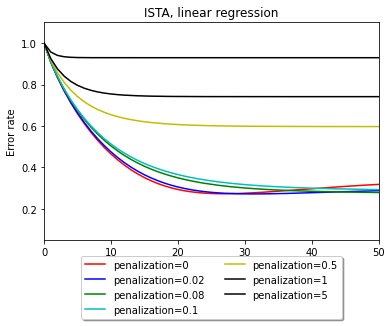

In [77]:
#Linear regression
fig = plt.figure()
plt.plot(lin1[2], 'r', label = 'penalization=0')
plt.plot(lin2[2], 'b', label = 'penalization=0.02')
plt.plot(lin3[2], 'g', label = 'penalization=0.08')
plt.plot(lin4[2], 'c', label = 'penalization=0.1')
plt.plot(lin5[2], 'y', label = 'penalization=0.5')
plt.plot(lin6[2], 'k', label = 'penalization=1')
plt.plot(lin7[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('ISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


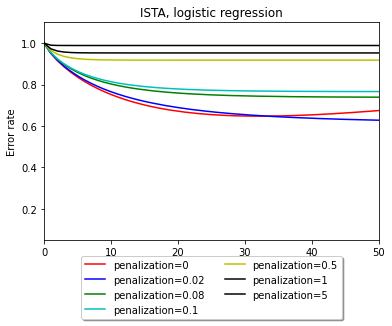

In [78]:
#Logistic regression
fig = plt.figure()
plt.plot(log1[2], 'r', label = 'penalization=0')
plt.plot(log2[2], 'b', label = 'penalization=0.02')
plt.plot(log3[2], 'g', label = 'penalization=0.08')
plt.plot(log4[2], 'c', label = 'penalization=0.1')
plt.plot(log5[2], 'y', label = 'penalization=0.5')
plt.plot(log6[2], 'k', label = 'penalization=1')
plt.plot(log7[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('ISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

#FISTA vs ISTA
Here we compare the performance of the two algorithms.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


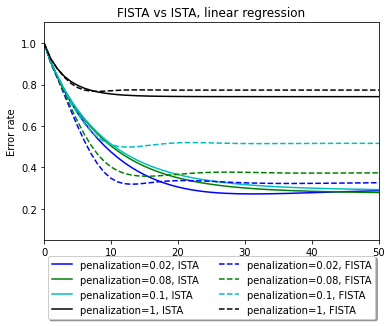

In [79]:
fig = plt.figure()
plt.plot(lin2[2], 'b', label = 'penalization=0.02, ISTA')
plt.plot(lin3[2], 'g', label = 'penalization=0.08, ISTA')
plt.plot(lin4[2], 'c', label = 'penalization=0.1, ISTA')
plt.plot(lin6[2], 'k', label = 'penalization=1, ISTA')
plt.plot(lin2f[2], 'b--', label = 'penalization=0.02, FISTA')
plt.plot(lin3f[2], 'g--', label = 'penalization=0.08, FISTA')
plt.plot(lin4f[2], 'c--', label = 'penalization=0.1, FISTA')
plt.plot(lin6f[2], 'k--', label = 'penalization=1, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


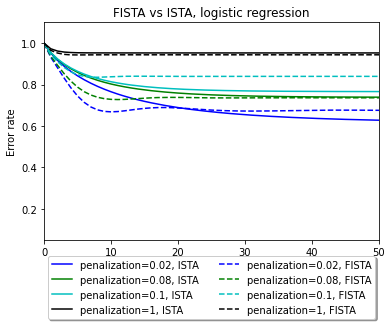

In [80]:
fig = plt.figure()
plt.plot(log2[2], 'b', label = 'penalization=0.02, ISTA')
plt.plot(log3[2], 'g', label = 'penalization=0.08, ISTA')
plt.plot(log4[2], 'c', label = 'penalization=0.1, ISTA')
plt.plot(log6[2], 'k', label = 'penalization=1, ISTA')
plt.plot(log2f[2], 'b--', label = 'penalization=0.02, FISTA')
plt.plot(log3f[2], 'g--', label = 'penalization=0.08, FISTA')
plt.plot(log4f[2], 'c--', label = 'penalization=0.1, FISTA')
plt.plot(log6f[2], 'k--', label = 'penalization=1, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()


#Comments
Here we see when the penalization is lower that Fista is also better than ISTA. 

#- Performance of the optimization algorithms for ridge and lasso penalizations

#FISTA

In [91]:
#linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin_r= fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
lin_l= fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

#logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log_r= fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
log_l= fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.58e-01 | 9.07e-01
      10 | 1.19e-01 | 3.09e-01
      20 | 1.23e-01 | 2.69e-01
      30 | 1.21e-01 | 2.56e-01
      40 | 1.21e-01 | 2.57e-01
      50 | 1.21e-01 | 2.58e-01
      60 | 1.21e-01 | 2.57e-01
      70 | 1.21e-01 | 2.57e-01
      80 | 1.21e-01 | 2.57e-01
      90 | 1.21e-01 | 2.57e-01
     100 | 1.21e-01 | 2.57e-01
     110 | 1.21e-01 | 2.57e-01
     120 | 1.21e-01 | 2.57e-01
     130 | 1.21e-01 | 2.57e-01
     140 | 1.21e-01 | 2.57e-01
     150 | 1.21e-01 | 2.57e-01
     160 | 1.21e-01 | 2.57e-01
     170 | 1.21e-01 | 2.57e-01
     180 | 1.21e-01 | 2.57e-01
     190 | 1.21e-01 | 2.57e-01
     200 | 1.21e-01 | 2.57e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.77e-01 | 9.10e-01
      10 | 1.93e-01 | 3.11e-01
      20 | 2.01e-01 | 2.40e-01
      30 | 1.98e-01 | 2.36e-01
      40 | 1.97e-01 | 2.35e-01
      50 | 1.98e-01 | 2.35e-01
      60 | 1.98e-01 | 2.35e-01
      70 | 1.98e-01 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


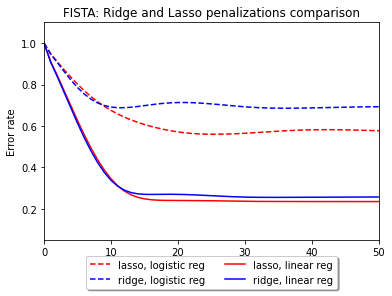

In [92]:
plt.plot(log_l[2], 'r--', label = 'lasso, logistic reg')
plt.plot(log_r[2], 'b--', label = 'ridge, logistic reg')
plt.plot(lin_l[2], 'r', label = 'lasso, linear reg')
plt.plot(lin_r[2], 'b', label = 'ridge, linear reg')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('FISTA: Ridge and Lasso penalizations comparison')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()


#Here the value of penalization is what we increase.

In [94]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin_r= fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin_l= fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.1, n_iter =200)

# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log_r= fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log_l= fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.1, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.30e-01 | 9.14e-01
      10 | 2.41e-01 | 3.85e-01
      20 | 2.50e-01 | 3.53e-01
      30 | 2.45e-01 | 3.66e-01
      40 | 2.47e-01 | 3.59e-01
      50 | 2.47e-01 | 3.62e-01
      60 | 2.46e-01 | 3.61e-01
      70 | 2.47e-01 | 3.61e-01
      80 | 2.46e-01 | 3.61e-01
      90 | 2.47e-01 | 3.61e-01
     100 | 2.47e-01 | 3.61e-01
     110 | 2.47e-01 | 3.61e-01
     120 | 2.47e-01 | 3.61e-01
     130 | 2.47e-01 | 3.61e-01
     140 | 2.47e-01 | 3.61e-01
     150 | 2.47e-01 | 3.61e-01
     160 | 2.47e-01 | 3.61e-01
     170 | 2.47e-01 | 3.61e-01
     180 | 2.47e-01 | 3.61e-01
     190 | 2.47e-01 | 3.61e-01
     200 | 2.47e-01 | 3.61e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.20e-01 | 9.41e-01
      10 | 4.95e-01 | 5.80e-01
      20 | 5.18e-01 | 5.40e-01
      30 | 5.07e-01 | 5.57e-01
      40 | 5.12e-01 | 5.50e-01
      50 | 5.10e-01 | 5.53e-01
      60 | 5.10e-01 | 5.52e-01
      70 | 5.10e-01 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


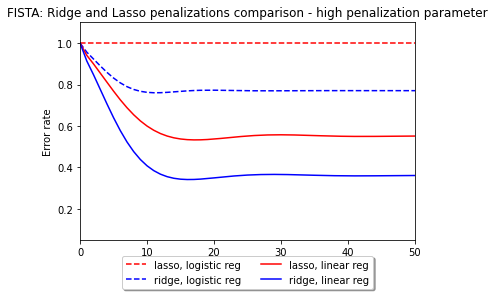

In [95]:
plt.plot(log_l[2], 'r--', label = 'lasso, logistic reg')
plt.plot(log_r[2], 'b--', label = 'ridge, logistic reg')
plt.plot(lin_l[2], 'r', label = 'lasso, linear reg')
plt.plot(lin_r[2], 'b', label = 'ridge, linear reg')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('FISTA: Ridge and Lasso penalizations comparison - high penalization parameter')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()

#ISTA

In [96]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin_r= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
lin_l= ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log_r= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
log_l= ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.36e-01 | 9.08e-01
      10 | 1.16e-01 | 5.02e-01
      20 | 1.06e-01 | 3.69e-01
      30 | 1.05e-01 | 3.13e-01
      40 | 1.06e-01 | 2.85e-01
      50 | 1.06e-01 | 2.71e-01
      60 | 1.06e-01 | 2.63e-01
      70 | 1.07e-01 | 2.59e-01
      80 | 1.07e-01 | 2.56e-01
      90 | 1.07e-01 | 2.55e-01
     100 | 1.07e-01 | 2.54e-01
     110 | 1.07e-01 | 2.53e-01
     120 | 1.07e-01 | 2.53e-01
     130 | 1.07e-01 | 2.52e-01
     140 | 1.07e-01 | 2.52e-01
     150 | 1.07e-01 | 2.52e-01
     160 | 1.07e-01 | 2.52e-01
     170 | 1.07e-01 | 2.52e-01
     180 | 1.07e-01 | 2.52e-01
     190 | 1.07e-01 | 2.52e-01
     200 | 1.07e-01 | 2.52e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.52e-01 | 9.11e-01
      10 | 1.75e-01 | 5.09e-01
      20 | 1.74e-01 | 3.69e-01
      30 | 1.76e-01 | 3.05e-01
      40 | 1.77e-01 | 2.72e-01
      50 | 1.78e-01 | 2.54e-01
      60 | 1.79e-01 | 2.44e-01
      70 | 1.79e-01 | 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


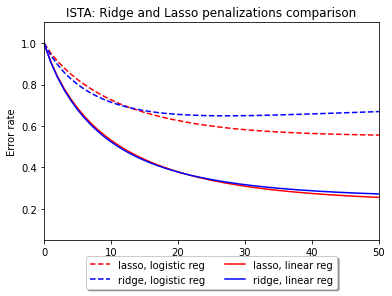

In [97]:
plt.plot(log_l[2], 'r--', label = 'lasso, logistic reg')
plt.plot(log_r[2], 'b--', label = 'ridge, logistic reg')
plt.plot(lin_l[2], 'r', label = 'lasso, linear reg')
plt.plot(lin_r[2], 'b', label = 'ridge, linear reg')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('ISTA: Ridge and Lasso penalizations comparison')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()


#Comments
Here we see that the penalization doesn't not do many modififications in the convergence. But when the parameter s which is the strength of penalizationis large we have an large error.